In [1]:
import pandas as pd
raw_data=pd.read_csv('../raw_data/Tool_Info.csv')
clean_data=pd.read_csv('../summary_data/table1_final.csv')
raw_data = raw_data.loc[:,['aligner', 'num_citations', 'wrapper_of']]
data = pd.merge(clean_data, raw_data, on='aligner', how='outer')
data.loc[data['aligner'] == 'PatternHunter', 'num_citations'] = 954
data.loc[data['aligner'] == 'LAMSA', 'num_citations'] = 14
data.loc[data['aligner'] == 'conLSH', 'num_citations'] = 1

data['age']=2020-data['year_of_pub']+1
data['citation_per_year']=data['num_citations']/data['age']
data.loc[data.loc[:,'aligner'] == 'HISAT2', 'citation_per_year'] = 95/2


# Creating new columns that combine rarer types
data.loc[data.loc[:,'indexing'] == 'hashing', 'index'] = 'Hashing'
data.loc[data.loc[:,'indexing'] == 'BWT-FM', 'index'] = 'BWT-FM'
data.loc[data.loc[:,'indexing'] == 'BWT-FM + hashing', 'index'] = 'BWT-FM & Hashing'
data.loc[data.loc[:,'indexing'] == 'suffix array', 'index'] = 'Other Suffix'
data.loc[data.loc[:,'indexing'] == 'BWT-ST', 'index'] = 'Other Suffix'
data.loc[data.loc[:,'indexing'] == 'suffix tree', 'index'] = 'Other Suffix'
data.loc[data.loc[:,'indexing'] == 'BWT', 'index'] = 'Other Suffix'

data.loc[data.loc[:,'pairwise_alignment'] == 'SW', 'pairwise'] = 'Smith-Waterman'
data.loc[data.loc[:,'pairwise_alignment'] == 'HD', 'pairwise'] = 'Hamming Distance'
data.loc[data.loc[:,'pairwise_alignment'] == 'NW', 'pairwise'] = 'Needleman-Wunsch'
data.loc[data.loc[:,'pairwise_alignment'] == 'Non-DP Heuristic', 'pairwise'] = 'Non-DP Heuristic'
data.loc[data.loc[:,'pairwise_alignment'] == 'Non-DP heuristic', 'pairwise'] = 'Non-DP Heuristic'
data.loc[data.loc[:,'pairwise_alignment'] == 'SW & NW', 'pairwise'] = 'Multiple Methods'
data.loc[data.loc[:,'pairwise_alignment'] == 'SW and NW', 'pairwise'] = 'Multiple Methods'
data.loc[data.loc[:,'pairwise_alignment'] == 'SW & Semi-Global', 'pairwise'] = 'Multiple Methods'
data.loc[data.loc[:,'pairwise_alignment'] == 'SW and Semi-Global', 'pairwise'] = 'Multiple Methods'
data.loc[data.loc[:,'pairwise_alignment'] == 'Rabin-Karp Algorithm', 'pairwise'] = 'Other DP'
data.loc[data.loc[:,'pairwise_alignment'] == 'Landau-Vishkin', 'pairwise'] = 'Other DP'
data.loc[data.loc[:,'pairwise_alignment'] == 'Sparse DP', 'pairwise'] = 'Other DP'
data.loc[data.loc[:,'pairwise_alignment'] == 'Banded Myers Bit Vector', 'pairwise'] = 'Other DP'
data.loc[data.loc[:,'pairwise_alignment'] == 'Myers Bit-Vector', 'pairwise'] = 'Other DP'
data.loc[data.loc[:,'pairwise_alignment'] == 'Semi-Global', 'pairwise'] = 'Other DP'
data.loc[data.loc[:,'pairwise_alignment'] == 'Semi-global', 'pairwise'] = 'Other DP'

data.loc[data.loc[:, 'wrapper'] == 'Y', 'wrap'] = 'Yes'
data.loc[data.loc[:, 'wrapper'] == 'N', 'wrap'] = 'No'
data.loc[data['aligner'] == 'LAMSA', 'wrapper_of'] = 'GEM'

data.loc[data.loc[:,'fix_length_seed'] == 'Y', 'seeds_fixed'] = 'Yes'
data.loc[data.loc[:,'fix_length_seed'] == 'N', 'seeds_fixed'] = 'No'

data.loc[data.loc[:,'seed_chaining'] == 'Y', 'seeds_chained'] = 'Yes'
data.loc[data.loc[:,'seed_chaining'] == 'N', 'seeds_chained'] = 'No'

data.loc[data.loc[:,'spaced_seed'] == 'Y', 'seeds_spaced'] = 'Yes'
data.loc[data.loc[:,'spaced_seed'] == 'N', 'seeds_spaced'] = 'No'

data_year = pd.DataFrame(data.loc[:,['year_of_pub', 'aligner', 'application', 'index', 'pairwise',
                              'seeds_fixed', 'seeds_spaced', 'seeds_chained', 'wrap', 'wrapper_of', 'citation_per_year']])

data_year.loc[data_year['wrap'] == 'Yes', :]

,year_of_pub,aligner,application,index,pairwise,seeds_fixed,seeds_spaced,seeds_chained,wrap,wrapper_of,citation_per_year
6,2003,BLASTZ,DNA,Hashing,Smith-Waterman,Yes,No,No,Yes,BlastZ,76.333333
16,2008,QPALMA,RNA-Seq,Other Suffix,Smith-Waterman,Yes,No,Yes,Yes,vmatch,13.384615
33,2009,TopHat,RNA-Seq,BWT-FM,Hamming Distance,Yes,No,No,Yes,Bowtie,757.000000
34,2010,BS-Seeker,BS-Seq,BWT-FM,Hamming Distance,Yes,No,No,Yes,Bowtie,19.545455
39,2010,Slider II,DNA,Hashing,Hamming Distance,Yes,No,No,Yes,Slider,5.727273
40,2010,VMATCH,DNA,Other Suffix,Smith-Waterman,Yes,No,Yes,Yes,NaN,5.909091
42,2010,MapSplice,RNA-Seq,BWT-FM,Hamming Distance,Yes,No,No,Yes,Bowtie,76.000000
44,2010,SpliceMap,RNA-Seq,Hashing,Hamming Distance,Yes,No,No,Yes,Bowtie,31.909091
46,2011,Bismark,BS-Seq,BWT-FM,Multiple Methods,Yes,No,Yes,Yes,Bowtie2 or HISAT2,155.000000
66,2012,Passion,RNA-Seq,Hashing,Smith-Waterman,Yes,No,Yes,Yes,SMALT,4.000000


In [2]:
rt = pd.read_csv('../raw_data/compare.tools.runtime.hours.csv')
mem = pd.read_csv('../raw_data/compare.tools.memory.csv')

In [3]:
rt.loc[:,'tools_lower'] = rt.loc[:,'Tools'].str.lower()
data_year.loc[:,'aligner_lower'] = data_year.loc[:,'aligner'].str.lower()
rtyear = pd.merge(rt, data_year, left_on='tools_lower', right_on='aligner_lower', how='inner')
rtyear.loc[:,'average_runtime'] = rtyear.iloc[:,1:11].mean(axis=1)
rtyear.loc[:,'std_dev'] = rtyear.iloc[:,1:11].std(axis=1)

# Imputing the one missing value
rtyear.loc[3,'ERR162843'] = rtyear.loc[3,'average_runtime'] 

# Only compare tools with DNA application
rtyear = rtyear.loc[rtyear.loc[:,'application'] != 'RNA-Seq'].reset_index(drop=True)

# Bowtie2 can be run in global or local, our data was generated using Needleman-Wunsch (Global)
rtyear.loc[rtyear.loc[:,'Tools'] == 'Bowtie2','pairwise'] = 'Needleman-Wunsch'
rtyear.loc[rtyear.loc[:,'Tools'] == 'last','pairwise'] = 'Smith-Waterman'
rtyear_summ = rtyear.loc[:,['aligner', 'year_of_pub', 'average_runtime', 'std_dev', 'application', 
                            'index', 'pairwise', 'seeds_fixed', 'seeds_spaced', 'seeds_chained', 'citation_per_year']]
rtyear_summ.loc[:,'Aligner'] = rtyear_summ.loc[:,'aligner']
#rtyear_summ.sort_values(by=['year_of_pub'], inplace=True)
for i in range(0,11):
    if rtyear.loc[i,'year_of_pub'] < 2013:
        rtyear.loc[i,'year_split'] = 'Before 2013'  
    else:
        rtyear.loc[i,'year_split'] = '2013 and later'
rtyear_melt = pd.melt(rtyear, id_vars = ['aligner', 'year_split', 'application', 'index', 'pairwise'], 
        value_vars = ['ERR009309', 'ERR013127', 'ERR013138', 'ERR045708', 'ERR050158', 'ERR162843', 'ERR181410',
                     'ERR183377', 'SRR061640', 'SRR360549'], value_name = 'runtime')
#rtyear.to_csv(path_or_buf='../summary_data/runtime_comparison_with_tool_info.csv')
rtyear_summ

,aligner,year_of_pub,average_runtime,std_dev,application,index,pairwise,seeds_fixed,seeds_spaced,seeds_chained,citation_per_year,Aligner
0,Bowtie2,2012,4.973137,2.040406,DNA,BWT-FM,Needleman-Wunsch,Yes,No,Yes,1786.777778,Bowtie2
1,Bowtie,2009,6.102213,2.942134,DNA,BWT-FM,Hamming Distance,Yes,No,No,1240.833333,Bowtie
2,BWA,2009,6.239311,2.106996,DNA,BWT-FM,Other DP,No,No,No,1678.583333,BWA
3,GSNAP,2010,20.924469,10.347573,DNA,Hashing,Non-DP Heuristic,Yes,No,Yes,140.818182,GSNAP
4,HISAT2,2019,1.158713,0.634037,DNA,BWT-FM,Non-DP Heuristic,Yes,No,No,47.500000,HISAT2
5,LAST,2011,20.221401,7.627339,DNA/BS-Seq/protein/RNA,Other Suffix,Smith-Waterman,No,Yes,No,56.500000,LAST
6,minimap2,2018,1.866426,0.694104,DNA/RNA-Seq,Hashing,Needleman-Wunsch,Yes,No,Yes,131.333333,minimap2
7,RMAP,2008,12.950420,4.114427,DNA,Hashing,Hamming Distance,Yes,No,No,29.615385,RMAP
8,SMALT,2010,32.163790,14.049867,DNA,Hashing,Smith-Waterman,Yes,No,Yes,2.454545,SMALT
9,SNAP,2011,1.165595,0.387181,DNA,Hashing,Needleman-Wunsch,Yes,No,No,13.100000,SNAP


In [4]:
mem.loc[:,'tools_lower'] = mem['Tools'].str.lower()
memyear = pd.merge(mem, data_year, left_on='tools_lower', right_on='aligner_lower', how='inner')
memyear.loc[:,'average_memory'] = memyear.iloc[:,1:11].mean(axis=1)
memyear = memyear.loc[memyear.loc[:,'application'] != 'RNA-Seq'].reset_index(drop=True)
memyear.loc[memyear.loc[:,'Tools'] == 'Bowtie2','pairwise'] = 'Needleman-Wunsch'
memyear.loc[memyear.loc[:,'Tools'] == 'last','pairwise'] = 'Smith-Waterman'

memyear_summ = memyear.loc[:,['aligner', 'year_of_pub', 'average_memory', 'application', 'index', 'citation_per_year',
                             'pairwise','seeds_fixed','seeds_spaced', 'seeds_chained',]]
memyear_summ.loc[:,'Aligner'] = memyear_summ.loc[:,'aligner']
#memyear_summ.sort_values(by=['year_of_pub'], inplace=True)
for i in range(0,11):
    memyear.loc[i,'year_split'] = 'Before 2013' if memyear.loc[i,'year_of_pub'] < 2013 else '2013 and later'
    
memyear_melt = pd.melt(memyear, id_vars = ['aligner', 'year_split', 'application', 'index', 'pairwise'], 
        value_vars = ['ERR009309', 'ERR013127', 'ERR013138', 'ERR045708', 'ERR050158', 'ERR162843', 'ERR181410',
                     'ERR183377', 'SRR061640', 'SRR360549'], value_name = 'memory')
#memyear.to_csv(path_or_buf='../summary_data/memory_comparison_with_tool_info.csv')
memyear_summ

,aligner,year_of_pub,average_memory,application,index,citation_per_year,pairwise,seeds_fixed,seeds_spaced,seeds_chained,Aligner
0,Bowtie2,2012,3.5799,DNA,BWT-FM,1786.777778,Needleman-Wunsch,Yes,No,Yes,Bowtie2
1,Bowtie,2009,3.1940,DNA,BWT-FM,1240.833333,Hamming Distance,Yes,No,No,Bowtie
2,BWA,2009,5.7110,DNA,BWT-FM,1678.583333,Other DP,No,No,No,BWA
3,GSNAP,2010,28.8536,DNA,Hashing,140.818182,Non-DP Heuristic,Yes,No,Yes,GSNAP
4,HISAT2,2019,4.6941,DNA,BWT-FM,47.500000,Non-DP Heuristic,Yes,No,No,HISAT2
5,LAST,2011,15.3589,DNA/BS-Seq/protein/RNA,Other Suffix,56.500000,Smith-Waterman,No,Yes,No,LAST
6,minimap2,2018,12.4488,DNA/RNA-Seq,Hashing,131.333333,Needleman-Wunsch,Yes,No,Yes,minimap2
7,RMAP,2008,9.5320,DNA,Hashing,29.615385,Hamming Distance,Yes,No,No,RMAP
8,SMALT,2010,3.6766,DNA,Hashing,2.454545,Smith-Waterman,Yes,No,Yes,SMALT
9,SNAP,2011,36.1000,DNA,Hashing,13.100000,Needleman-Wunsch,Yes,No,No,SNAP


In [5]:
idx_rt = pd.read_csv('../raw_data/compare.tools.index.csv')

data_year.loc[:,'aligner_lower'] = data_year.loc[:,'aligner'].str.lower()
idx_rt.loc[:,'tools_lower'] = idx_rt.loc[:,'Tools'].str.lower()

rtidx = pd.merge(idx_rt, data_year, left_on='tools_lower', 
                 right_on='aligner_lower', how='inner').loc[:,['aligner', 'application', 'year_of_pub',
                                                               'Runtime','Virtual Mem (G)', 'index']]
rtidx = rtidx.loc[rtidx.loc[:,'application'].str.contains('DNA'),:]
rtidx = rtidx.loc[rtidx.loc[:,'aligner'] != 'MOSAIK']
rtidx = rtidx.dropna().reset_index(drop=True)
t = pd.DatetimeIndex(rtidx.loc[:,'Runtime'])
rtidx.loc[:,'Runtime (hours)'] = (t.hour*60 + t.minute)/60
rtidx

,aligner,application,year_of_pub,Runtime,Virtual Mem (G),index,Runtime (hours)
0,Bowtie2,DNA,2012,1:53:39,5.398,BWT-FM,1.883333
1,Bowtie,DNA,2009,1:42:21,5.395,BWT-FM,1.700000
2,BWA,DNA,2009,1:10:43,4.448,BWT-FM,1.166667
3,GSNAP,DNA,2010,1:08:32,19.561,Hashing,1.133333
4,HISAT2,DNA,2019,1:07:14,5.394,BWT-FM,1.116667
5,LAST,DNA/BS-Seq/protein/RNA,2011,0:55:16,28.148,Other Suffix,0.916667
6,segemehl,DNA,2009,1:26:45,57.773,Other Suffix,1.433333
7,SMALT,DNA,2010,0:01:58,6.668,Hashing,0.016667
8,SNAP,DNA,2011,4:04:26,39.313,Hashing,4.066667
9,Subread,DNA/RNA-Seq,2013,0:18:53,6.853,Hashing,0.300000


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import scipy as scp
import numpy as np

tool_clrs = ['teal', 'palegreen', 'purple', 'deepskyblue', 'magenta', 'maroon', 
        'darkorange', 'limegreen', 'turquoise', 'blue']

cite_clrs = ['teal', 'purple', 'palegreen', 'deepskyblue', 'magenta', 'maroon', 'khaki', 
        'darkorange', 'limegreen', 'turquoise', 'blue']

index_clrs = ['darkorange', 'mediumorchid', 'cornflowerblue', 'navy']

local_clrs = ['orange', 'deepskyblue', 'chocolate', 'gold', 'royalblue', 'lightseagreen']

order_by_year = ["segemehl", "Bowtie", "BWA", "GSNAP", "SMALT", "LAST", "SNAP", "Bowtie2", "Subread", "HISAT2"]

cite_order_by_year = ["RMAP", "Bowtie", "BWA", "GSNAP", "SMALT", "LAST", "SNAP", "Bowtie2", "Subread", 
                 "HISAT2", "minimap2"]

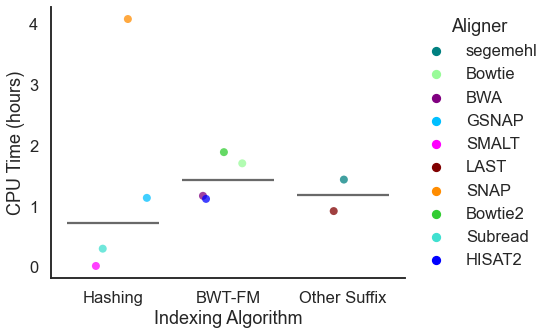

In [30]:
plt.figure(figsize=(8,5))

medians = rtidx.groupby('index').median()
upper = rtidx.groupby('index').quantile(q=.75)
lower = rtidx.groupby('index').quantile(q=.25)

sns.set_style('white')
sns.set_context('talk')
#ax = sns.boxplot(data = rtidx, x = 'index', y = 'Runtime (hours)', whis=0,
#                 order = ['Hashing', 'BWT-FM', 'Other Suffix'], color="1", fliersize = 0)
ax = sns.stripplot(data= rtidx, x = 'index', y = 'Runtime (hours)', order=['Hashing','BWT-FM','Other Suffix'],
                   palette=tool_clrs, hue="aligner", hue_order=order_by_year, size=8, jitter=.3, alpha=.75)
ax.set(xlabel = 'Indexing Algorithm', ylabel = 'CPU Time (hours)')
leg = plt.legend(title='Aligner', loc='center left', bbox_to_anchor=(1, .5), frameon=False)

#plt.hlines(upper.loc[upper.index == 'Hashing','Runtime (hours)'], -.05, .05, color="dimgray", linestyle='solid')
#plt.hlines(lower.loc[lower.index == 'Hashing','Runtime (hours)'], -.05, .05, color="dimgray", linestyle='solid')
#plt.vlines(0, lower.loc[lower.index == 'Hashing','Runtime (hours)'], upper.loc[upper.index == 'Hashing','Runtime (hours)'], 
#          color="dimgray", linestyle='solid')
plt.hlines(medians.loc[medians.index == 'Hashing','Runtime (hours)'], -.4, .4, color="dimgray", linestyle='solid')
#plt.hlines(upper.loc[upper.index == 'BWT-FM','Runtime (hours)'], .95, 1.05, color="dimgray", linestyle='solid')
#plt.hlines(lower.loc[lower.index == 'BWT-FM','Runtime (hours)'], .95, 1.05, color="dimgray", linestyle='solid')
#plt.vlines(1, lower.loc[lower.index == 'BWT-FM','Runtime (hours)'], upper.loc[upper.index == 'BWT-FM','Runtime (hours)'], 
#           color="dimgray", linestyle='solid')
plt.hlines(medians.loc[medians.index == 'BWT-FM','Runtime (hours)'], 0.6, 1.4, color="dimgray", linestyle='solid')
#plt.hlines(upper.loc[upper.index == 'Other Suffix','Runtime (hours)'], 1.95, 2.05, color="dimgray", linestyle='solid')
#plt.hlines(lower.loc[lower.index == 'Other Suffix','Runtime (hours)'], 1.95, 2.05, color="dimgray", linestyle='solid')
#plt.vlines(2, lower.loc[lower.index == 'Other Suffix','Runtime (hours)'], upper.loc[upper.index == 'Other Suffix',
#                                                                                    'Runtime (hours)'], 
#           color="dimgray", linestyle='solid')
plt.hlines(medians.loc[medians.index == 'Other Suffix','Runtime (hours)'], 1.6, 2.4, color="dimgray", linestyle='solid')

plt.tight_layout()
sns.despine()


plt.savefig('../figures/FigureS1_a.png')
plt.savefig('../figures/FigureS1_a.pdf')

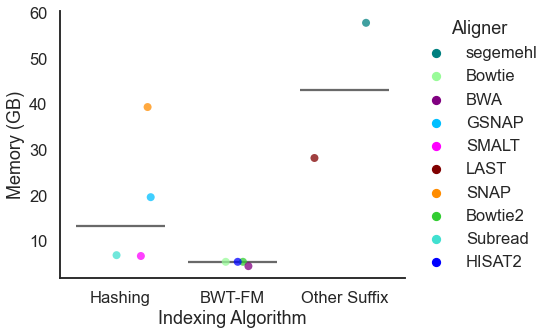

In [32]:
plt.figure(figsize=(8,5))

sns.set_style('white')
sns.set_context('talk')

medians = rtidx.groupby('index').median()
upper = rtidx.groupby('index').quantile(q=.75)
lower = rtidx.groupby('index').quantile(q=.25)

#ax = sns.boxplot(data = rtidx, x = 'index', y = 'Virtual Mem (G)', whis=0,
#                 order = ['Hashing', 'BWT-FM', 'Other Suffix'], color="1", fliersize = 0)
ax = sns.stripplot(data= rtidx, x = 'index', y = 'Virtual Mem (G)', order=['Hashing','BWT-FM','Other Suffix'],
                   palette=tool_clrs, hue="aligner", hue_order=order_by_year, size=8, jitter=.3, alpha=.75)
ax.set(xlabel = 'Indexing Algorithm', ylabel = 'Memory (GB)')
leg = plt.legend(title='Aligner', loc='center left', bbox_to_anchor=(1, .5), frameon=False)

#plt.hlines(upper.loc[upper.index == 'Hashing','Virtual Mem (G)'], -.05, .05, color="dimgray", linestyle='solid')
#plt.hlines(lower.loc[lower.index == 'Hashing','Virtual Mem (G)'], -.05, .05, color="dimgray", linestyle='solid')
#plt.vlines(0, lower.loc[lower.index == 'Hashing','Virtual Mem (G)'], upper.loc[upper.index == 'Hashing','Virtual Mem (G)'], 
#           color="dimgray", linestyle='solid')
plt.hlines(medians.loc[medians.index == 'Hashing','Virtual Mem (G)'], -.4, .4, color="dimgray", linestyle='solid')
#plt.hlines(upper.loc[upper.index == 'BWT-FM','Virtual Mem (G)'], .95, 1.05, color="dimgray", linestyle='solid')
#plt.hlines(lower.loc[lower.index == 'BWT-FM','Virtual Mem (G)'], .95, 1.05, color="dimgray", linestyle='solid')
#plt.vlines(1, lower.loc[lower.index == 'BWT-FM','Virtual Mem (G)'], upper.loc[upper.index == 'BWT-FM','Virtual Mem (G)'], 
#           color="dimgray", linestyle='solid')
plt.hlines(medians.loc[medians.index == 'BWT-FM','Virtual Mem (G)'], 0.6, 1.4, color="dimgray", linestyle='solid')
#plt.hlines(upper.loc[upper.index == 'Other Suffix','Virtual Mem (G)'], 1.95, 2.05, color="dimgray", linestyle='solid')
#plt.hlines(lower.loc[lower.index == 'Other Suffix','Virtual Mem (G)'], 1.95, 2.05, color="dimgray", linestyle='solid')
#plt.vlines(2, lower.loc[lower.index == 'Other Suffix','Virtual Mem (G)'], upper.loc[upper.index == 'Other Suffix','Virtual Mem (G)'], 
#           color="dimgray", linestyle='solid')
plt.hlines(medians.loc[medians.index == 'Other Suffix','Virtual Mem (G)'], 1.6, 2.4, color="dimgray", linestyle='solid')

plt.tight_layout()
sns.despine()

plt.savefig('../figures/FigureS1_b.png')
plt.savefig('../figures/FigureS1_b.pdf')

In [9]:
rna_tools = pd.DataFrame(data_year.loc[data_year.application.str.contains('RNA'),:])
rna_tools

,year_of_pub,aligner,application,index,pairwise,seeds_fixed,seeds_spaced,seeds_chained,wrap,wrapper_of,citation_per_year,aligner_lower
16,2008,QPALMA,RNA-Seq,Other Suffix,Smith-Waterman,Yes,No,Yes,Yes,vmatch,13.384615,qpalma
33,2009,TopHat,RNA-Seq,BWT-FM,Hamming Distance,Yes,No,No,Yes,Bowtie,757.000000,tophat
42,2010,MapSplice,RNA-Seq,BWT-FM,Hamming Distance,Yes,No,No,Yes,Bowtie,76.000000,mapsplice
43,2010,MicroRazerS,RNA-Seq,Hashing,Hamming Distance,Yes,No,Yes,No,RazerS,4.000000,microrazers
44,2010,SpliceMap,RNA-Seq,Hashing,Hamming Distance,Yes,No,No,Yes,Bowtie,31.909091,splicemap
45,2010,Supersplat,RNA-Seq,Hashing,NaN,No,No,No,No,NaN,5.363636,supersplat
47,2011,LAST,DNA/BS-Seq/protein/RNA,Other Suffix,Multiple Methods,No,Yes,No,No,NaN,56.500000,last
54,2011,SOAPSplice,RNA-Seq,BWT-FM,Non-DP Heuristic,Yes,No,No,No,NaN,12.300000,soapsplice
65,2012,OSA,RNA-Seq,Hashing,NaN,Yes,No,No,No,NaN,8.666667,osa
66,2012,Passion,RNA-Seq,Hashing,Smith-Waterman,Yes,No,Yes,Yes,SMALT,4.000000,passion


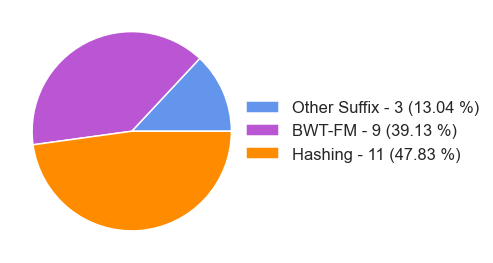

In [10]:
plt.figure(figsize=(11,4))

sns.set_style('white')
sns.set_context('talk')

idx_group = rna_tools.groupby('index').count().sort_values('aligner', ascending=True)
patches, texts = plt.pie(idx_group.aligner, colors=index_clrs[2::-1])
pct = 100.*idx_group.aligner/idx_group.aligner.sum()
labels = ['{0} - {1} ({2:2.2f} %)'.format(i,j,k) for i,j,k in zip(idx_group.index, idx_group.aligner, pct)]
plt.legend(patches, labels, loc='center left', bbox_to_anchor=(.9, .5), frameon=False)
#plt.show()
plt.tight_layout()
sns.despine()

plt.savefig('../figures/FigureS2_0.png')
plt.savefig('../figures/FigureS2_0.pdf')

<Figure size 576x288 with 0 Axes>

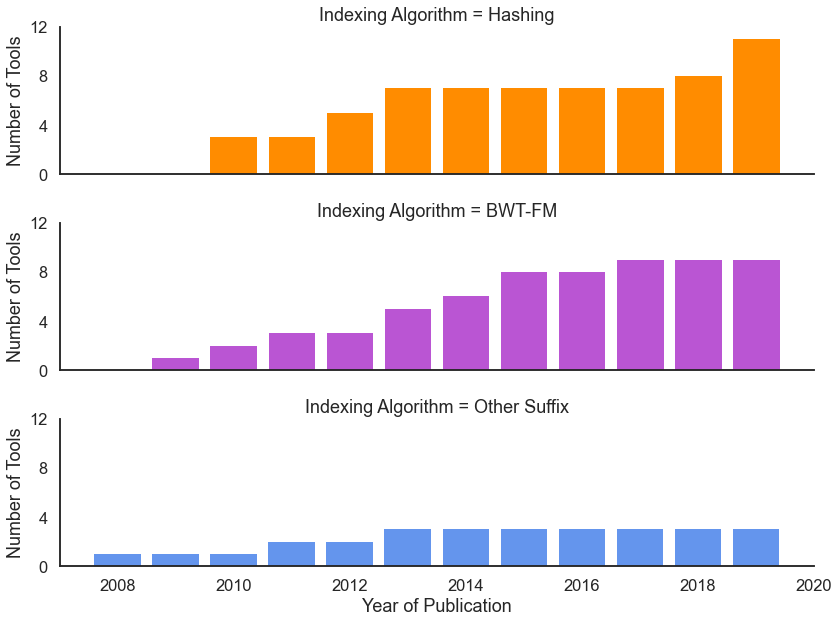

In [11]:
plt.figure(figsize=(8,4))

idx = range(min(rna_tools['year_of_pub']), max(rna_tools['year_of_pub'])+1)
by_year = rna_tools.groupby(['year_of_pub','index']).count()
by_year = by_year.xs('aligner', axis=1)
by_year = by_year.unstack(level = -1, fill_value=0)
by_year = by_year.cumsum()
by_year = by_year.reindex(idx, method='ffill')
#by_year.loc[:,'Total'] = by_year.sum(axis=1)
x = by_year.index
by_year.reset_index()
year_melt = pd.melt(by_year.reset_index(), id_vars=['year_of_pub'], var_name='Indexing Algorithm', 
                    value_name='Number of Tools')
year_melt = year_melt.rename(columns={'year_of_pub':'Year of Publication'})

sns.set_style('white')
sns.set_context('talk')

g = sns.FacetGrid(year_melt, row='Indexing Algorithm', aspect=4, hue='Indexing Algorithm', 
                  row_order=['Hashing', 'BWT-FM', 'Other Suffix'],
                  palette=index_clrs, hue_order=['Hashing', 'BWT-FM', 'Other Suffix'])
g = g.map(plt.bar, 'Year of Publication', 'Number of Tools', linewidth=0)
plt.xticks(range(min(rna_tools['year_of_pub']), max(rna_tools['year_of_pub'])+2, 2))
plt.ylim(0,12)
plt.yticks(range(0, 13, 4))
sns.despine()


plt.tight_layout()
plt.savefig('../figures/FigureS2_1.png')
plt.savefig('../figures/FigureS2_1.pdf')

In [12]:
rna_wrappers = rna_tools[rna_tools.wrap == 'Yes']
rna_nonwrappers = rna_tools[rna_tools.wrap == 'No']

rna_wrappers

,year_of_pub,aligner,application,index,pairwise,seeds_fixed,seeds_spaced,seeds_chained,wrap,wrapper_of,citation_per_year,aligner_lower
16,2008,QPALMA,RNA-Seq,Other Suffix,Smith-Waterman,Yes,No,Yes,Yes,vmatch,13.384615,qpalma
33,2009,TopHat,RNA-Seq,BWT-FM,Hamming Distance,Yes,No,No,Yes,Bowtie,757.000000,tophat
42,2010,MapSplice,RNA-Seq,BWT-FM,Hamming Distance,Yes,No,No,Yes,Bowtie,76.000000,mapsplice
44,2010,SpliceMap,RNA-Seq,Hashing,Hamming Distance,Yes,No,No,Yes,Bowtie,31.909091,splicemap
66,2012,Passion,RNA-Seq,Hashing,Smith-Waterman,Yes,No,Yes,Yes,SMALT,4.000000,passion
76,2013,TopHat2,RNA-Seq,BWT-FM,Multiple Methods,Yes,No,Yes,Yes,Bowtie2,893.250000,tophat2
84,2014,JAGuaR,RNA-Seq,BWT-FM,Smith-Waterman,Yes,No,No,Yes,BWA,3.000000,jaguar
85,2015,ContextMap 2,RNA-Seq,BWT-FM,Multiple Methods,Yes,No,Yes,Yes,"Bowtie, Bowtie2, or BWA",5.166667,contextmap 2


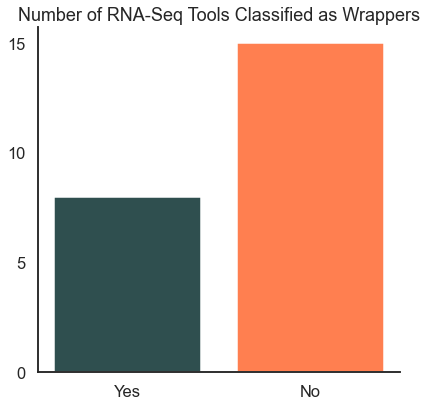

In [13]:
plt.figure(figsize=(6,6))

sns.set_style('white')
sns.set_context('talk')
idx_group = rna_tools.groupby('wrap').count().sort_values('aligner', ascending=True)
ax = plt.bar(idx_group.index, idx_group.aligner, color=['darkslategray', 'coral'])
pct = 100.*idx_group.aligner/idx_group.aligner.sum()

plt.title("Number of RNA-Seq Tools Classified as Wrappers")
plt.yticks(range(0,16,5))
#plt.show()

sns.despine()
plt.tight_layout()
plt.savefig('../figures/FigureS3_0.png')
plt.savefig('../figures/FigureS3_0.pdf')

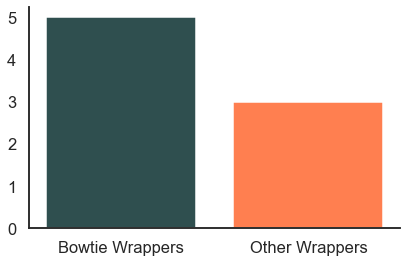

In [14]:
plt.figure(figsize=(6,4))

sns.set_style('white')
sns.set_context('talk')

bowtie_tools = rna_wrappers.loc[rna_wrappers.wrapper_of.str.contains('Bowtie'),:]
num_b = len(bowtie_tools)
num_o = len(rna_wrappers) - num_b
ax = plt.bar(['Bowtie Wrappers', 'Other Wrappers'], [num_b, num_o], color=['darkslategray', 'coral'])

#plt.title("Number of RNA-Seq Tools Wrapping Bowtie")
#plt.show()

sns.despine()
plt.tight_layout()
plt.savefig('../figures/FigureS3_1.png')
plt.savefig('../figures/FigureS3_1.pdf')

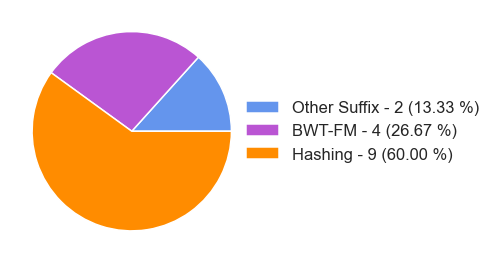

In [15]:
plt.figure(figsize=(11,4))

sns.set_style('white')
sns.set_context('talk')
idx_group = rna_nonwrappers.groupby('index').count().sort_values('aligner', ascending=True)
patches, texts = plt.pie(idx_group.aligner, colors=index_clrs[2::-1])
pct = 100.*idx_group.aligner/idx_group.aligner.sum()
labels = ['{0} - {1} ({2:2.2f} %)'.format(i,j,k) for i,j,k in zip(idx_group.index, idx_group.aligner, pct)]
plt.legend(patches, labels, loc='center left', bbox_to_anchor=(.9, .5), frameon=False)
#plt.show()
plt.tight_layout()
sns.despine()
plt.savefig('../figures/FigureS4_0.png')
plt.savefig('../figures/FigureS4_0.pdf')

<Figure size 576x288 with 0 Axes>

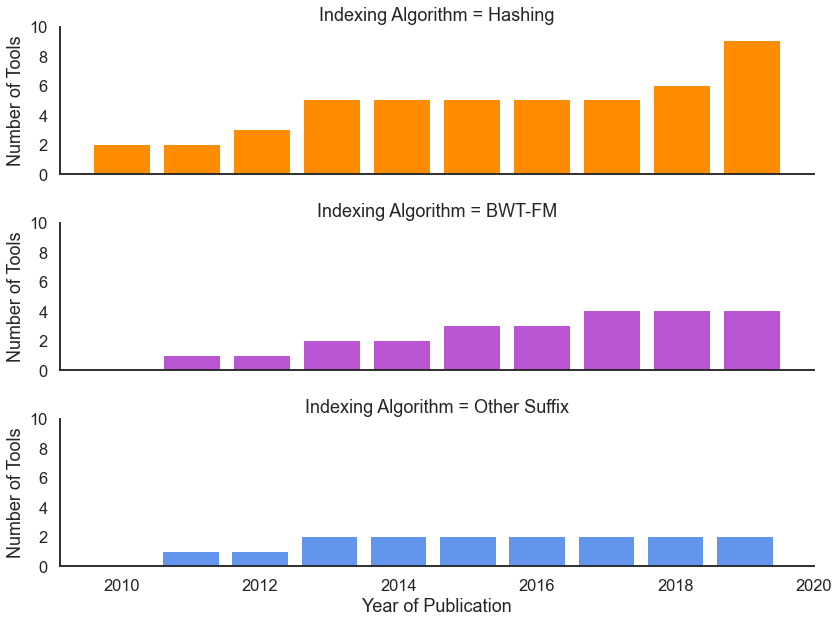

In [16]:
plt.figure(figsize=(8,4))

idx = range(min(rna_nonwrappers['year_of_pub']), max(rna_nonwrappers['year_of_pub'])+1)
by_year = rna_nonwrappers.groupby(['year_of_pub','index']).count()
by_year = by_year.xs('aligner', axis=1)
by_year = by_year.unstack(level = -1, fill_value=0)
by_year = by_year.cumsum()
by_year = by_year.reindex(idx, method='ffill')
#by_year.loc[:,'Total'] = by_year.sum(axis=1)
x = by_year.index
by_year.reset_index()
year_melt = pd.melt(by_year.reset_index(), id_vars=['year_of_pub'], var_name='Indexing Algorithm', 
                    value_name='Number of Tools')
year_melt = year_melt.rename(columns={'year_of_pub':'Year of Publication'})

sns.set_style('white')
sns.set_context('talk')

g = sns.FacetGrid(year_melt, row='Indexing Algorithm', aspect=4, hue='Indexing Algorithm', 
                  row_order=['Hashing', 'BWT-FM', 'Other Suffix'],
                  palette=index_clrs, hue_order=['Hashing', 'BWT-FM', 'Other Suffix'])
g = g.map(plt.bar, 'Year of Publication', 'Number of Tools', linewidth=0)
plt.xticks(range(min(rna_nonwrappers['year_of_pub']), max(rna_nonwrappers['year_of_pub'])+2, 2))
plt.ylim(0,10)
plt.yticks(range(0,11,2))
sns.despine()

plt.tight_layout()
plt.savefig('../figures/FigureS4_1.png')
plt.savefig('../figures/FigureS4_1.pdf')

In [17]:
bs_tools = pd.DataFrame(data_year.loc[data_year.application.str.contains('BS'),:])
bs_tools

,year_of_pub,aligner,application,index,pairwise,seeds_fixed,seeds_spaced,seeds_chained,wrap,wrapper_of,citation_per_year,aligner_lower
17,2009,BRAT,BS-Seq,Hashing,Hamming Distance,Yes,No,No,No,NaN,5.333333,brat
18,2009,BSMAP,BS-Seq,Hashing,Hamming Distance,Yes,No,No,No,NaN,45.000000,bsmap
34,2010,BS-Seeker,BS-Seq,BWT-FM,Hamming Distance,Yes,No,No,Yes,Bowtie,19.545455,bs-seeker
46,2011,Bismark,BS-Seq,BWT-FM,Multiple Methods,Yes,No,Yes,Yes,Bowtie2 or HISAT2,155.000000,bismark
47,2011,LAST,DNA/BS-Seq/protein/RNA,Other Suffix,Multiple Methods,No,Yes,No,No,NaN,56.500000,last
55,2012,BRAT-BW,BS-Seq,BWT-FM,Hamming Distance,No,No,No,No,NaN,7.777778,brat-bw
67,2013,BS-Seeker2,BS-Seq,BWT-FM,Multiple Methods,Yes,No,Yes,Yes,Bowtie2,21.625000,bs-seeker2
87,2016,ERNE 2,DNA/BS-Seq,BWT-FM & Hashing,Hamming Distance,Yes,No,No,No,NaN,1.800000,erne 2
100,2019,BatMeth2,BS-Seq,BWT-FM,Multiple Methods,Yes,No,Yes,No,NaN,1.000000,batmeth2


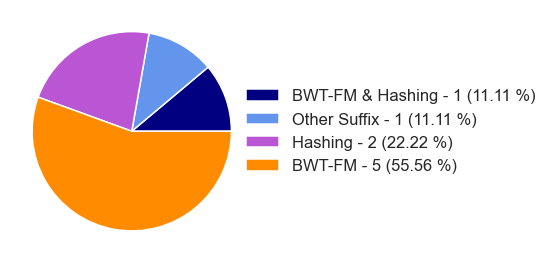

In [18]:
plt.figure(figsize=(11,4))

sns.set_style('white')
sns.set_context('talk')

idx_group = bs_tools.groupby('index').count().sort_values('aligner', ascending=True)
patches, texts = plt.pie(idx_group.aligner, colors=index_clrs[::-1])
pct = 100.*idx_group.aligner/idx_group.aligner.sum()
labels = ['{0} - {1} ({2:2.2f} %)'.format(i,j,k) for i,j,k in zip(idx_group.index, idx_group.aligner, pct)]
plt.legend(patches, labels, loc='center left', bbox_to_anchor=(.9, .5), frameon=False)
#plt.show()
plt.tight_layout()
sns.despine()

plt.savefig('../figures/FigureS5_0.png')
plt.savefig('../figures/FigureS5_0.pdf')

<Figure size 576x288 with 0 Axes>

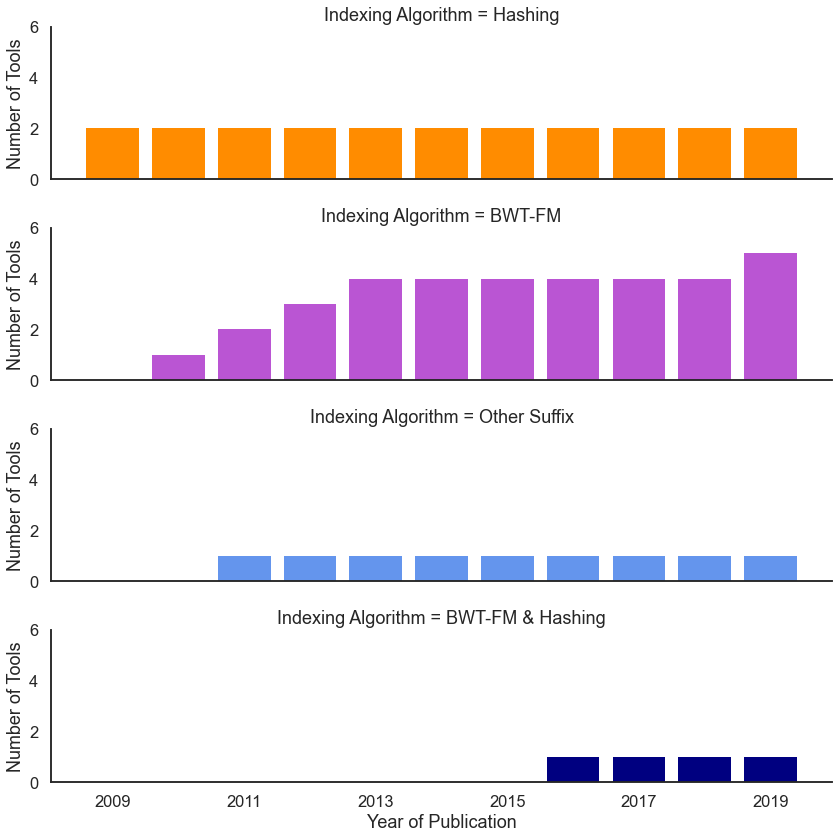

In [19]:
plt.figure(figsize=(8,4))

idx = range(min(bs_tools['year_of_pub']), max(bs_tools['year_of_pub'])+1)
by_year = bs_tools.groupby(['year_of_pub','index']).count()
by_year = by_year.xs('aligner', axis=1)
by_year = by_year.unstack(level = -1, fill_value=0)
by_year = by_year.cumsum()
by_year = by_year.reindex(idx, method='ffill')
#by_year.loc[:,'Total'] = by_year.sum(axis=1)
x = by_year.index
by_year.reset_index()
year_melt = pd.melt(by_year.reset_index(), id_vars=['year_of_pub'], var_name='Indexing Algorithm', 
                    value_name='Number of Tools')
year_melt = year_melt.rename(columns={'year_of_pub':'Year of Publication'})

sns.set_style('white')
sns.set_context('talk')

g = sns.FacetGrid(year_melt, row='Indexing Algorithm', aspect=4, hue='Indexing Algorithm', 
                  row_order=['Hashing', 'BWT-FM', 'Other Suffix', 'BWT-FM & Hashing'],
                  palette=index_clrs, hue_order=['Hashing', 'BWT-FM', 'Other Suffix', 'BWT-FM & Hashing'])
g = g.map(plt.bar, 'Year of Publication', 'Number of Tools', linewidth=0)
plt.xticks(range(min(bs_tools['year_of_pub']), max(bs_tools['year_of_pub'])+2, 2))
plt.ylim(0,6)
sns.despine()

plt.tight_layout()
plt.savefig('../figures/FigureS5_1.png')
plt.savefig('../figures/FigureS5_1.pdf')

In [20]:
bs_wrappers = bs_tools[bs_tools.wrap == 'Yes']
bs_nonwrappers = bs_tools[bs_tools.wrap == 'No']

bs_wrappers

,year_of_pub,aligner,application,index,pairwise,seeds_fixed,seeds_spaced,seeds_chained,wrap,wrapper_of,citation_per_year,aligner_lower
34,2010,BS-Seeker,BS-Seq,BWT-FM,Hamming Distance,Yes,No,No,Yes,Bowtie,19.545455,bs-seeker
46,2011,Bismark,BS-Seq,BWT-FM,Multiple Methods,Yes,No,Yes,Yes,Bowtie2 or HISAT2,155.000000,bismark
67,2013,BS-Seeker2,BS-Seq,BWT-FM,Multiple Methods,Yes,No,Yes,Yes,Bowtie2,21.625000,bs-seeker2


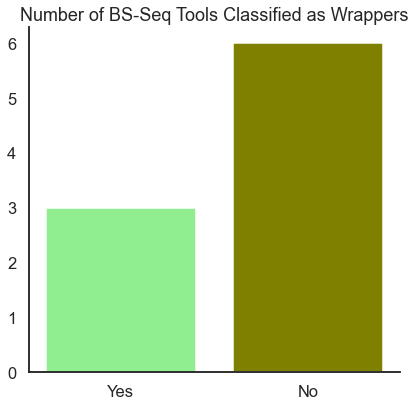

In [21]:
plt.figure(figsize=(6,6))

sns.set_style('white')
sns.set_context('talk')
idx_group = bs_tools.groupby('wrap').count().sort_values('aligner', ascending=True)
ax = plt.bar(idx_group.index, idx_group.aligner, color=['lightgreen', 'olive'])
pct = 100.*idx_group.aligner/idx_group.aligner.sum()

plt.title("Number of BS-Seq Tools Classified as Wrappers")
#plt.show()

sns.despine()
plt.tight_layout()
plt.savefig('../figures/FigureS6_0.png')
plt.savefig('../figures/FigureS6_0.pdf')

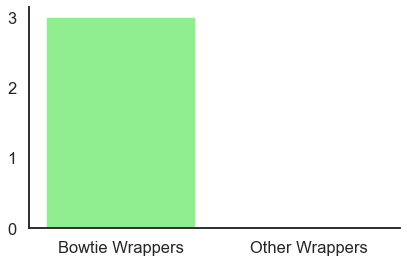

In [22]:
plt.figure(figsize=(6,4))

sns.set_style('white')
sns.set_context('talk')

bowtie_tools = bs_wrappers.loc[bs_wrappers.wrapper_of.str.contains('Bowtie'),:]
num_b = len(bowtie_tools)
num_o = len(bs_wrappers) - num_b
ax = plt.bar(['Bowtie Wrappers', 'Other Wrappers'], [num_b, num_o], color=['lightgreen', 'olive'])

#plt.title("Number of RNA-Seq Tools Classified as Wrappers")
#plt.show()

sns.despine()
plt.tight_layout()

plt.savefig('../figures/FigureS6_1.png')
plt.savefig('../figures/FigureS6_1.pdf')

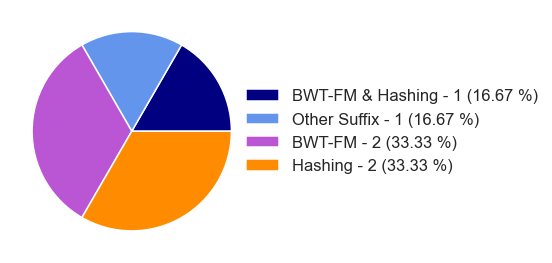

In [23]:
plt.figure(figsize=(11,4))

sns.set_style('white')
sns.set_context('talk')
idx_group = bs_nonwrappers.groupby('index').count().sort_values('aligner', ascending=True)
patches, texts = plt.pie(idx_group.aligner, colors=index_clrs[::-1])
pct = 100.*idx_group.aligner/idx_group.aligner.sum()
labels = ['{0} - {1} ({2:2.2f} %)'.format(i,j,k) for i,j,k in zip(idx_group.index, idx_group.aligner, pct)]
plt.legend(patches, labels, loc='center left', bbox_to_anchor=(.9, .5), frameon=False)
#plt.show()
plt.tight_layout()
sns.despine()
plt.savefig('../figures/FigureS7_0.png')
plt.savefig('../figures/FigureS7_0.pdf')

<Figure size 432x216 with 0 Axes>

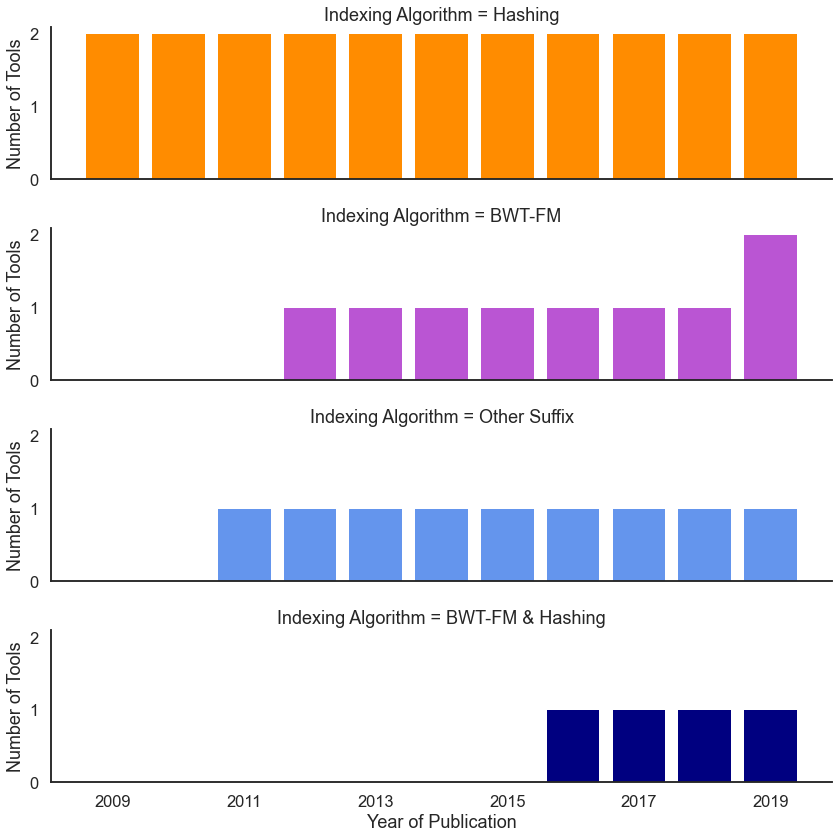

In [24]:
plt.figure(figsize=(6,3))

idx = range(min(bs_nonwrappers['year_of_pub']), max(bs_nonwrappers['year_of_pub'])+1)
by_year = bs_nonwrappers.groupby(['year_of_pub','index']).count()
by_year = by_year.xs('aligner', axis=1)
by_year = by_year.unstack(level = -1, fill_value=0)
by_year = by_year.cumsum()
by_year = by_year.reindex(idx, method='ffill')
#by_year.loc[:,'Total'] = by_year.sum(axis=1)
x = by_year.index
by_year.reset_index()
year_melt = pd.melt(by_year.reset_index(), id_vars=['year_of_pub'], var_name='Indexing Algorithm', 
                    value_name='Number of Tools')
year_melt = year_melt.rename(columns={'year_of_pub':'Year of Publication'})

sns.set_style('white')
sns.set_context('talk')

g = sns.FacetGrid(year_melt, row='Indexing Algorithm', aspect=4, hue='Indexing Algorithm', 
                  row_order=['Hashing', 'BWT-FM', 'Other Suffix', 'BWT-FM & Hashing'],
                  palette=index_clrs, hue_order=['Hashing', 'BWT-FM', 'Other Suffix', 'BWT-FM & Hashing'])
g = g.map(plt.bar, 'Year of Publication', 'Number of Tools', linewidth=0)
plt.xticks(range(min(bs_tools['year_of_pub']), max(bs_tools['year_of_pub'])+2, 2))
sns.despine()

plt.tight_layout()
plt.savefig('../figures/FigureS7_1.png')
plt.savefig('../figures/FigureS7_1.pdf')

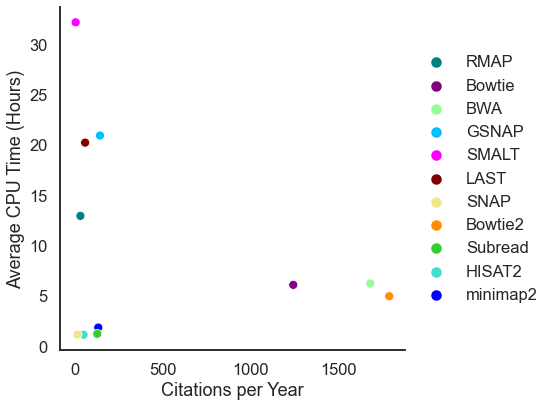

In [25]:
plt.figure(figsize=(8,6))

sns.set_style('white')
sns.set_context('talk')

ax = sns.scatterplot(data = rtyear_summ, x = 'citation_per_year', 
                     y = 'average_runtime', hue='Aligner', palette=cite_clrs, hue_order=cite_order_by_year)

ax.set(xlabel = 'Citations per Year', ylabel = 'Average CPU Time (Hours)')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, frameon=False)
sns.despine()
#plt.show()

plt.tight_layout()
plt.savefig('../figures/FigureS8_a.png')
plt.savefig('../figures/FigureS8_a.pdf')

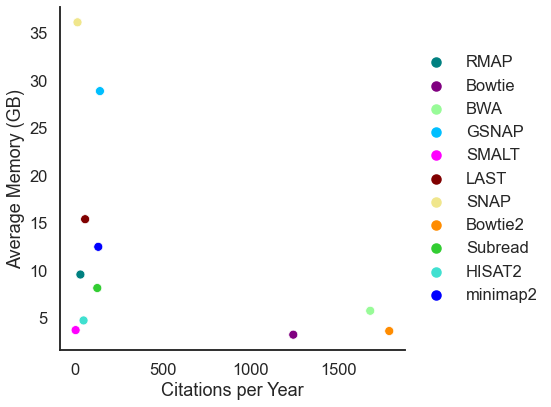

In [26]:
plt.figure(figsize=(8,6))

sns.set_style('white')
sns.set_context('talk')

ax = sns.scatterplot(data = memyear_summ, x = 'citation_per_year', 
                     y = 'average_memory', hue='Aligner', palette=cite_clrs, hue_order=cite_order_by_year)

ax.set(xlabel = 'Citations per Year', ylabel = 'Average Memory (GB)')
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), ncol=1, frameon=False)
sns.despine()
#plt.show()

plt.tight_layout()
plt.savefig('../figures/FigureS8_b.png')
plt.savefig('../figures/FigureS8_b.pdf')